## Maximize the likelihood for different values of n_s


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
from iminuit import Minuit
# our modules
import camb_cosmo
import CAMB_model
import full_theory
import likelihood
import data_MPGADGET
import gp_emulator
import p1d_arxiv
import iminuit_minimizer

Setup mock data, from one of simulations in the suite

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label=15
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

will drop sim number 15 from emulator


In [3]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max=4.0
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                skewers_label=skewers_label,
                                sim_label=test_sim_label,
                                zmax=z_max)

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 1.7654E-09, n_s = 9.6590E-01, alpha_s = 0.0000E+00


Setup archive of P1D measurements from simulations to train the emulator

In [4]:
# specify redshift range
z_max=4
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc)
emu.load_default()

 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


In [6]:
# get true cosmology in test simulation
sim_cosmo=data.mock_sim.sim_cosmo
true_As=sim_cosmo.InitPower.As
true_ns=sim_cosmo.InitPower.ns
true_H0=sim_cosmo.H0
true_mnu=camb_cosmo.get_mnu(sim_cosmo)
print('true As =',true_As)
print('true ns =',true_ns)
print('true H_0 =',true_H0)
print('true mnu =',true_mnu)

true As = 1.765434e-09
true ns = 0.965899
true H_0 = 67.0
true mnu = 0.0


### Find overall maximum (including free n_s)

In [7]:
theory=full_theory.FullTheory(zs=data.z,emulator=emu)
print('use default cosmo as fiducial')
camb_cosmo.print_info(theory.camb_model_fid.cosmo)

use default cosmo as fiducial
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


In [8]:
like_params=["As","ns","ln_tau_0","ln_sigT_kms_0","ln_gamma_0"]
like_param_limits=[[1.0e-9,3.0e-9 ], [0.90, 1.00], [-0.2, 0.2],
            [-0.5, 0.5], [-0.2, 0.2]]
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,
                            prior_Gauss_rms=0.5)

will run migrad


 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


------------------------------------------------------------------
| FCN = 27.94                   |     Ncalls=483 (483 total)     |
| EDM = nan (Goal: 0.0001)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
will compute Hessian matrix
best-fit values = [0.61711772 0.99984981 0.61329722 0.87985953 0.30964208]


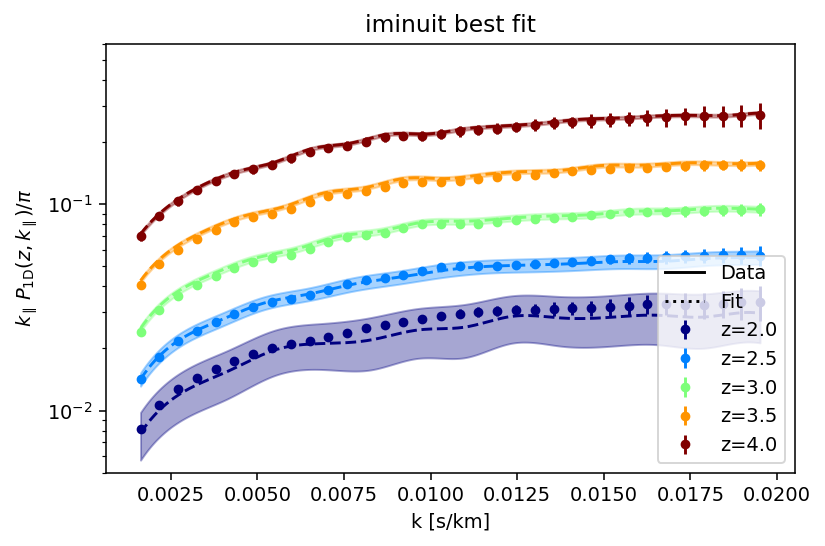

In [9]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)
minimizer.minimize()
best_fit_values=minimizer.minimizer.np_values()
minimizer.plot_best_fit(plot_every_iz=2)

### Maximize likelihood for different values of n_s

In [10]:
# define free likelihood parameters (without ns now)
like_params=["As","ln_tau_0","ln_sigT_kms_0","ln_gamma_0"]
like_param_limits=[[1.0e-9,3.0e-9 ], [-0.2, 0.2], [-0.5, 0.5], [-0.2, 0.2]]
# choose starting point (best-fit values, except ns)
start=np.delete(best_fit_values, 1)
print('starting values',start)

starting values [0.61711772 0.61329722 0.87985953 0.30964208]


In [11]:
Nns=11
nss=np.linspace(true_ns-0.03,true_ns+0.03,Nns)
likelihoods=[]
for ns in nss:
    cosmo_fid=camb_cosmo.get_cosmology(ns=ns)
    camb_model_fid=CAMB_model.CAMBModel(zs=data.z,cosmo=cosmo_fid)
    theory=full_theory.FullTheory(zs=data.z,emulator=emu,camb_model_fid=camb_model_fid)
    print('use fiducial cosmology with ns=',ns)
    like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,prior_Gauss_rms=0.5)
    likelihoods.append(like)

use fiducial cosmology with ns= 0.9358989999999999
use fiducial cosmology with ns= 0.9418989999999999
use fiducial cosmology with ns= 0.9478989999999999
use fiducial cosmology with ns= 0.9538989999999999
use fiducial cosmology with ns= 0.959899
use fiducial cosmology with ns= 0.965899
use fiducial cosmology with ns= 0.971899
use fiducial cosmology with ns= 0.977899
use fiducial cosmology with ns= 0.983899
use fiducial cosmology with ns= 0.989899
use fiducial cosmology with ns= 0.995899


In [12]:
results=[]
for like in likelihoods:
    ## Evaluate log_prob at random point in parameter space
    chi2_test=like.get_chi2(start)
    print('starting chi2',chi2_test)
    # setup minuit
    m = Minuit.from_array_func(like.minus_log_prob,start=start,error=0.02,errordef=0.5)
    # run optimiser
    m.migrad()
    # compute Hesse covariance
    m.hesse()
    # store results from iminuit
    results.append(m)
    min_chi2=like.get_chi2(m.values)
    print('minimum chi2',min_chi2)

starting chi2 141.23713011509395
minimum chi2 16.433003387359918
starting chi2 128.28009000737214
minimum chi2 12.734094359080316
starting chi2 116.86738903552548
minimum chi2 8.244594124368852
starting chi2 107.2684094685169
minimum chi2 5.460879550905324
starting chi2 99.10644350622728
minimum chi2 4.109240485893998
starting chi2 92.34692133238603
minimum chi2 3.920645062577051
starting chi2 87.18745977812094
minimum chi2 4.639020573290706
starting chi2 83.8236435344076
minimum chi2 6.012732524476554
starting chi2 82.02611268396817


 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


minimum chi2 7.985031346614706
starting chi2 80.63123524667336
minimum chi2 10.405087575604199
starting chi2 77.8257677733126
minimum chi2 12.561590427470678


In [13]:
best_fit_chi2=[likelihoods[p].get_chi2(values=results[p].values) for p in range(Nns)]
best_fit_As=[likelihoods[p].parameters_from_sampling_point(results[p].values)[0].value for p in range(Nns)]

In [14]:
# convoluted way to get error on As and ns
error_As=[likelihoods[p].parameters_from_sampling_point(results[p].np_values()+results[p].np_errors())[0].value - best_fit_As[p] for p in range(Nns) ]

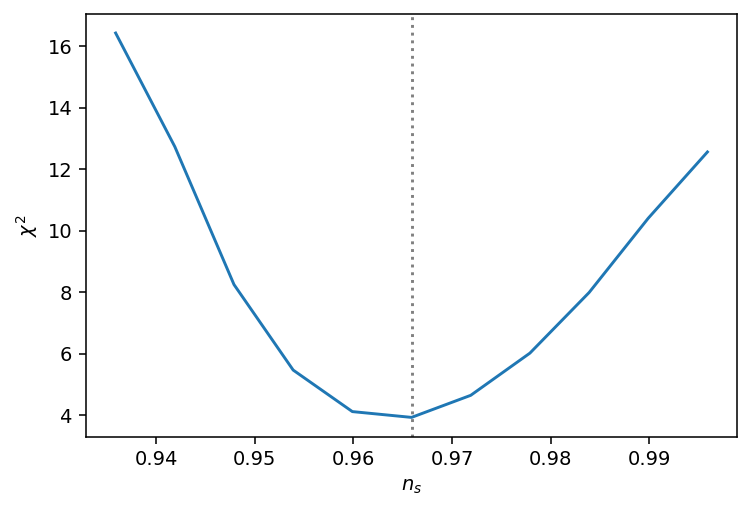

In [15]:
plt.plot(nss,best_fit_chi2)
#plt.ylim(0,20)
plt.axvline(x=sim_cosmo.InitPower.ns,ls=':',color='gray')
plt.xlabel(r'$n_s$')
plt.ylabel(r'$\chi^2$');

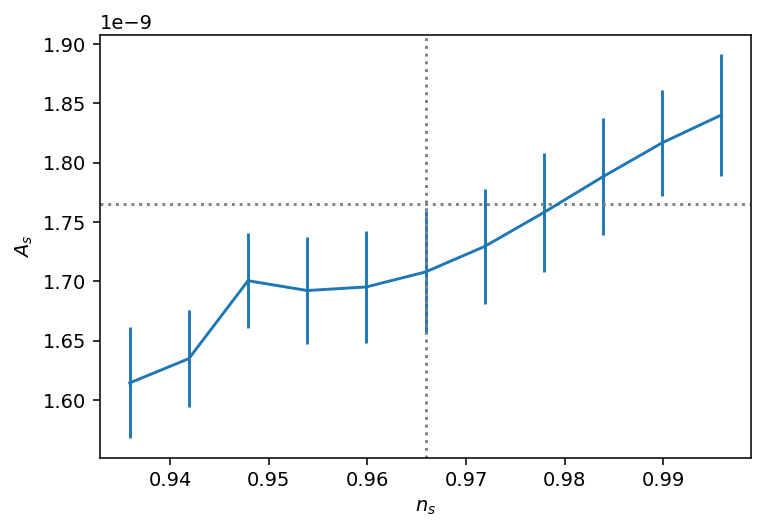

In [16]:
plt.errorbar(nss,best_fit_As,yerr=error_As)
plt.axvline(x=sim_cosmo.InitPower.ns,ls=':',color='gray')
plt.axhline(y=sim_cosmo.InitPower.As,ls=':',color='gray')
plt.xlabel(r'$n_s$')
plt.ylabel(r'$A_s$');